# Forecast Time-Series Individual vs Group

After the time-series data is partition into groups, fit a forecast model. See how forecast model using data from indiviual series is different from forecast model using data from the whole data points in the group.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, fcluster
from fastcluster import linkage
from itertools import combinations
from scipy.spatial.distance import  correlation, cosine, euclidean, cityblock
from fastdtw import fastdtw





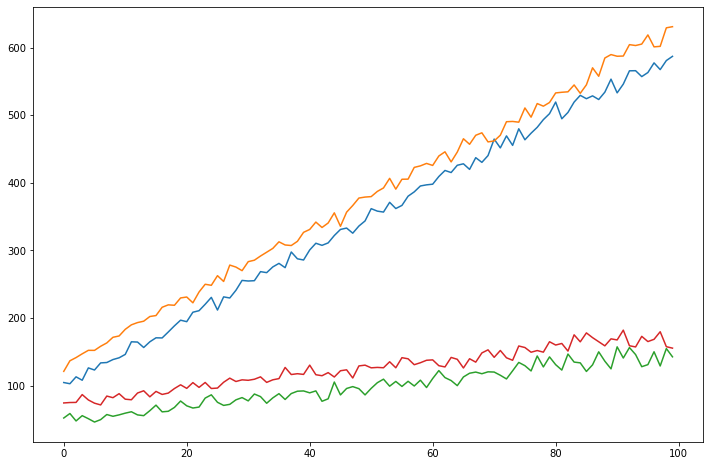

In [2]:
x = np.arange(0,100)
iid_noise = lambda : np.random.normal(0,5,x.size)
m_std = 0.1

def time_series_data_type1(m, c, m_std = 0.1):
    m = m + np.random.normal(0,m_std,100)
    c = c + iid_noise()
    y = m * x + c
    return y

dgf_1 = time_series_data_type1

y1 = dgf_1(m=5, c=100)
y2 = dgf_1(m=5, c=130)
y3 = dgf_1(m=1, c=50)
y4 = dgf_1(m=1, c=75)

plt.figure(figsize=(12,8))
plt.plot(x, y1, x, y2, x, y3, x, y4)
plt.show()

## Clustering

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'dcoord': [[0.0, 735.7512234844226, 735.7512234844226, 0.0],
  [0.0, 971.6159117100685, 971.6159117100685, 0.0],
  [735.7512234844226,
   18066.902491568988,
   18066.902491568988,
   971.6159117100685]],
 'ivl': ['y1', 'y2', 'y3', 'y4'],
 'leaves': [0, 1, 2, 3],
 'color_list': ['g', 'r', 'b']}

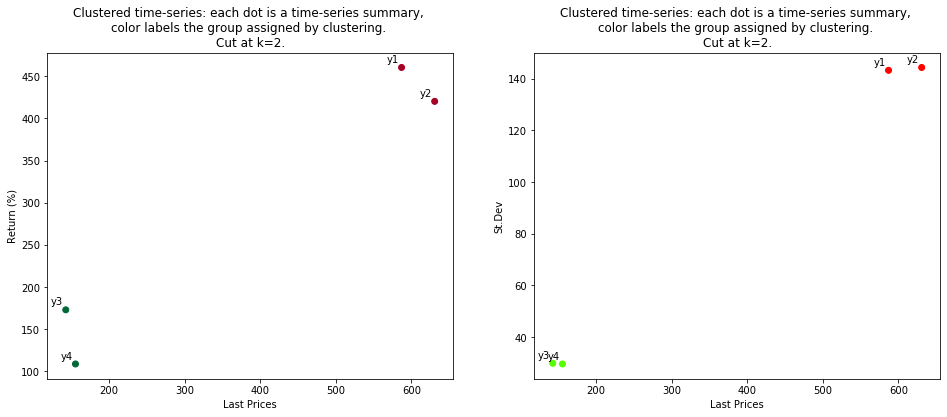

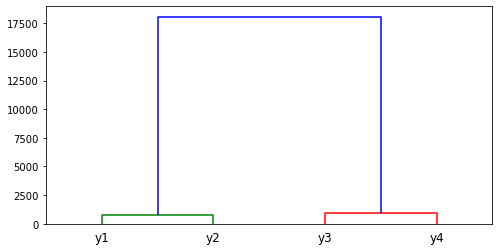

In [3]:
class TimeSeriesCluster:
    """Main class for time-series clustering. See above imports for required libraries.
    
        The helper functions can be staticmethod, but maybe we need shared variable at class level.
    """
    def __init__(self, timeline, series, labels):
        """Receive timeline, time-series items, and object labels.

            Ex.
            labels = ['y1', 'y2', 'y3', 'y4']
            items = [y1, y2, y3, y4]
        """
        
        # choose distance function
        d_func = self.dtw_dist_ret
        
        self.items = series # map series to a list of item. Our definition define 
        self.labels = labels # object labels
        
        self.D = pdist(self.items, d_func) # compute distance table
        #  show squareform(D) in distance_matrix property 
        
        self.Z = linkage(self.D, method='single')

        
        # Uncomment to show dendrogram
        # fig = plt.figure(figsize=(8, 4))
        # dn = dendrogram(Z, labels=labels)

        self.k = 2
        
        # clusters # the output labels
        self.clusters = fcluster(self.Z, self.k, criterion='maxclust')
        
        
    @property
    def distance_matrix(self):
        return squareform(self.D)
    
    def plot_dendrogram(self):
        plt.figure(figsize=(8, 4))
        dn = dendrogram(self.Z, labels=self.labels)
        return dn
    
    def plot_results(self):
        # plot with first value and last value 
        labels, X, clusters = self.labels, self.items, self.clusters
        
        # obtain K from cluster 
        k = np.unique(clusters).size

        # X[0] # this is pd.Series object
        firsts = np.array(list(map(lambda ts: ts[0], X)))  # Standard deviation is X-axis
        lasts = np.array(list(map(lambda ts: ts[-1], X))) # Mean is Y-axis

        returns = (lasts - firsts) / firsts * 100 # Returns in pct

        plt.figure(figsize=(16, 6))
        # Plot 1
        plt.subplot(1,2,1)
        plt.scatter(lasts, returns, c=clusters, cmap='RdYlGn')  # plot points with cluster dependent colors
        plt.title("Clustered time-series: each dot is a time-series summary, \ncolor labels the group assigned by clustering. \nCut at k=%s." % k)
        plt.xlabel("Last Prices")
        plt.ylabel("Return (%)")

        # Add label:
        for label, x, y in zip(labels, lasts, returns):
            plt.annotate(
                label,
                xy=(x, y), xytext=(-3, 3),
                textcoords='offset points', ha='right', va='bottom')

        # Plot 2
        plt.subplot(1,2,2)
        st_devs = list(map(np.std, X))  # Standard deviation is X-axis
        means = list(map(lambda ts: np.mean(ts), X)) # Mean is Y-axis
        plt.scatter(lasts, st_devs, c=clusters, cmap='prism')  # plot points with cluster dependent colors
        plt.title("Clustered time-series: each dot is a time-series summary, \ncolor labels the group assigned by clustering. \nCut at k=%s." % k)
        plt.xlabel("Last Prices")
        plt.ylabel("St.Dev")

        # Add label:
        for label, x, y in zip(labels, lasts, st_devs):
            plt.annotate(
                label,
                xy=(x, y), xytext=(-3, 3),
                textcoords='offset points', ha='right', va='bottom')
    @classmethod
    def compute_daily_returns(cls, ts):
        # daily return for Numpy array
        tmp = ts.copy()    
        tmp = np.roll(tmp,1) # np.roll(ts2.copy(), 1)
        ret = np.log(ts[1:]/tmp[1:]) # log-return
        return ret
    @classmethod
    def my_dtw_dist(cls, u, v):
        # use FastDTW (approximation of DTW) to measure dissimarity
        r1 = compute_daily_returns(u)
        r2 = compute_daily_returns(v)
        return fastdtw(r1,r2)[0]
    @classmethod
    def dtw_dist_ret(cls, u, v):
        # use FastDTW (approximation of DTW) to measure dissimarity. This generally works on price series.
        # If series received is returns series, use cumsum() to reconstruct price series.
        # 
        # If want to explore further transformation, try: compute_daily_returns and my_dtw_dist
        return fastdtw(u,v)[0]


labels = ['y1', 'y2', 'y3', 'y4']
items = [y1, y2, y3, y4]

tsc1 = TimeSeriesCluster(timeline=x, series=items, labels=labels)
tsc1.plot_results()
tsc1.plot_dendrogram()

Did not use log-transform of the series to cluster. This is reflected in the plot of return, std.dev, and last value below.

In [4]:
# Linear forecast model

In [5]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

t, v = x[:, np.newaxis], y1 # Newaxis trick follow the example

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(t, v) # find slope and intercept

LinearRegression()

Coefficients: 
 [4.95659903]


Text(0.5, 1.0, 'Blue is a forecast model (hypothesis h_line1) obtained by fitting to the data points.')

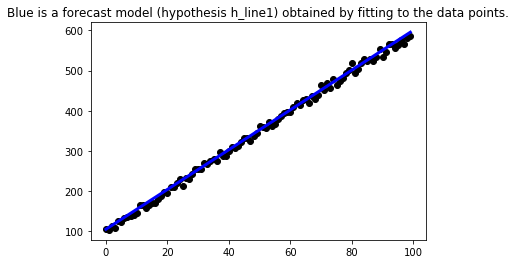

In [6]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f'
#       % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(t, v,  color='black')

# Our model H is y = m * x + c
# - m is the slope which is the coefficient
# - c is the bias or in this case the first data point (left-most value).

m = regr.coef_
c = v[0]

y_hat = m * x + c  # this is the model for linear forecast.

plt.plot(x, y_hat, color='blue', linewidth=3)

plt.xticks()
plt.yticks()

plt.title("Blue is a forecast model (hypothesis h_line1) obtained by fitting to the data points.")

In [7]:
# knowing hypothesis  h_line1, we build a forecast model.

def h_line(m, c, t):
    """t parameter is the x-axis or the time horizon. 
        This can be x from the arange define at the top of this notebook.
        
        TODO: replace to use convention t afterward."""
    # m is the slope
    assert isinstance(m[0], np.float64)
    y_hat = m * t + c  # this is the model for linear forecast.

    return y_hat
    
h1 = h_line(m, c, x)

In [8]:
def make_hypothesis(data, t):
    """Returns a linear forecast model."""

    # Newaxis trick follow the example
    # data is np.array of values of
    t, v = t[:, np.newaxis], data 
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
    regr.fit(t, v) # find slope and intercept
    
    # Our model H is y = m * x + c
    # - m is the slope which is the coefficient
    # - c is the bias or in this case the first data point (left-most value).

    m = regr.coef_
    c = v[0]
    
    y_hat = m * t + c  # this is the model for linear forecast.
    return y_hat, m, c

In [9]:
y1_hat, m1_hat, c1_hat = make_hypothesis(y1, x)
y2_hat, m2_hat, c2_hat = make_hypothesis(y2, x)
y3_hat, m3_hat, c3_hat = make_hypothesis(y3, x)
y4_hat, m4_hat, c4_hat = make_hypothesis(y4, x)

Text(0.5, 1.0, 'Black=actual Blue=model(h_line)')

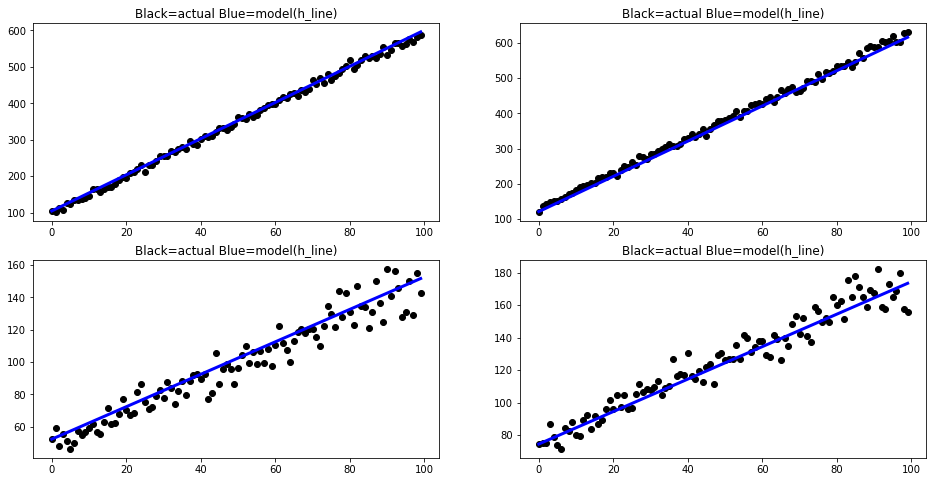

In [10]:
axes = plt.figure(figsize=(16,8))
# Plot outputs
plt.subplot(2,2,1)
plt.scatter(x, y1,  color='black')
plt.plot(x, y1_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,2)
plt.scatter(x, y2,  color='black')
plt.plot(x, y2_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,3)
plt.scatter(x, y3,  color='black')
plt.plot(x, y3_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,4)
plt.scatter(x, y4,  color='black')
plt.plot(x, y4_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

In [55]:
# make the forecast model general. So can change hypothesis class or technique later.
# forecast model is a hypothesis class.


class ForecastModel:
    def __init__(self, timeline, data):
        self.t = timeline.astype(np.int)
        self.y = data
        y_hat, slope, intercept = self.make_hypothesis(data, timeline)
        self.y_hat = y_hat.reshape((self.y.size,)) # make data same dimension
        self.slope = slope[0] # keep just the first coefficient. Note that for multivariate regression this will be vectors
        self.intercept = intercept
        self.errors = self.fitting_errors()
        self.avg_error = np.average(self.errors)
    def make_hypothesis(self, data, t):
        """Returns a linear forecast model."""

        # Newaxis trick follow the example
        # data is np.array of values of
        t, v = t[:, np.newaxis], data 

        # Create linear regression object
        regr = linear_model.LinearRegression()
        regr.fit(t, v) # find slope and intercept

        # Our model H is y = m * x + c
        # - m is the slope which is the coefficient
        # - c is the bias or in this case the first data point (left-most value).

        m = regr.coef_
        c = v[0]

        y_hat = m * t + c  # this is the model for linear forecast.
        
        return y_hat, m, c
    def fitting_errors(self):
        return self.y - self.y_hat
    
    def forecast(self, y_train, horizon=60):
        """Stores data in t_forecast variable and y_forecast variable. return the portion of the forecast."""
        steps = horizon # time steps to forecast
        
        # use linear model to make forecast.
        # Returns forecast values.
        
        # last value becomes the intercept c.
        last_value = y_train[-1]  # TODO: consider change the name of y to y train
        c = self.intercept # use the intercept from fitting stage!
        # needing y_train as input feels wired. But without this we can get confused if the self.y has future data or not.
        
        
        # the t here is the steps
        # t = steps to step into the future
        
        # slope comes from the hypothesis already fitted.
        m = self.slope
        
        # time-index for the forecasted period
        self.t_forecast = np.arange(60) + self.t[-1] + 1
        
        # y_hat = m * t + c
        
        self.y_forecast = m * self.t_forecast + c
        return self.y_forecast
    
    def __repr__(self):
        avg_err = self.avg_error
        return """LinearModel slope=%s intercept=%s error=%s""" % (self.slope, self.intercept, avg_err)

fm1 = ForecastModel(x, y1)
fm2 = ForecastModel(x, y2)
fm3 = ForecastModel(x, y3)
fm4 = ForecastModel(x, y4)

fm1, fm2, fm3, fm4

(LinearModel slope=4.9565990327094545 intercept=104.73939121060467 error=-3.072207699284778,
 LinearModel slope=4.994161585502532 intercept=121.25783561147759 error=9.148111914394319,
 LinearModel slope=1.003896575960724 intercept=52.308286610359836 error=-3.1273637303242827,
 LinearModel slope=0.9990546477362229 intercept=74.55933642672318 error=1.8577357033141655)

Text(0.5, 1.0, 'Fit linear model individual series.')

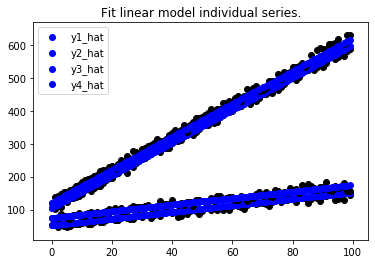

In [56]:
plt.scatter(x, fm1.y,  color='black')
plt.scatter(x, fm1.y_hat,  color='blue', label='y1_hat')

plt.scatter(x, fm2.y,  color='black')
plt.scatter(x, fm2.y_hat,  color='blue', label='y2_hat')

plt.scatter(x, fm3.y,  color='black')
plt.scatter(x, fm3.y_hat,  color='blue', label='y3_hat')

plt.scatter(x, fm4.y,  color='black')
plt.scatter(x, fm4.y_hat,  color='blue', label='y4_hat')

plt.legend()
plt.title("Fit linear model individual series.")

In [57]:
# do train / test split
# 80/20

# get training values
train_val = lambda v: v[:int(x.size*0.5)]
# get test values
test_val = lambda v: v[int(x.size*0.7):]

x_train = train_val(x)
y1_train = train_val(y1)
y2_train = train_val(y2)
y3_train = train_val(y3)
y4_train = train_val(y4)

x_test = test_val(x)
y1_test = test_val(y1)
y2_test = test_val(y2)
y3_test = test_val(y3)
y4_test = test_val(y4)

fm1 = ForecastModel(x_train, y1_train)
fm2 = ForecastModel(x_train, y2_train)
fm3 = ForecastModel(x_train, y3_train)
fm4 = ForecastModel(x_train, y4_train)

fm1, fm2, fm3, fm4

(LinearModel slope=5.0169448511702 intercept=104.73939121060467 error=-4.9347979014774195,
 LinearModel slope=4.980807889479101 intercept=121.25783561147759 error=9.731284819987065,
 LinearModel slope=0.9627552667576851 intercept=52.308286610359836 error=-2.330595244596113,
 LinearModel slope=1.0846818115741224 intercept=74.55933642672318 error=-0.06594799643424608)

Text(0.5, 1.0, 'Black=actual Blue=model(h_line)')

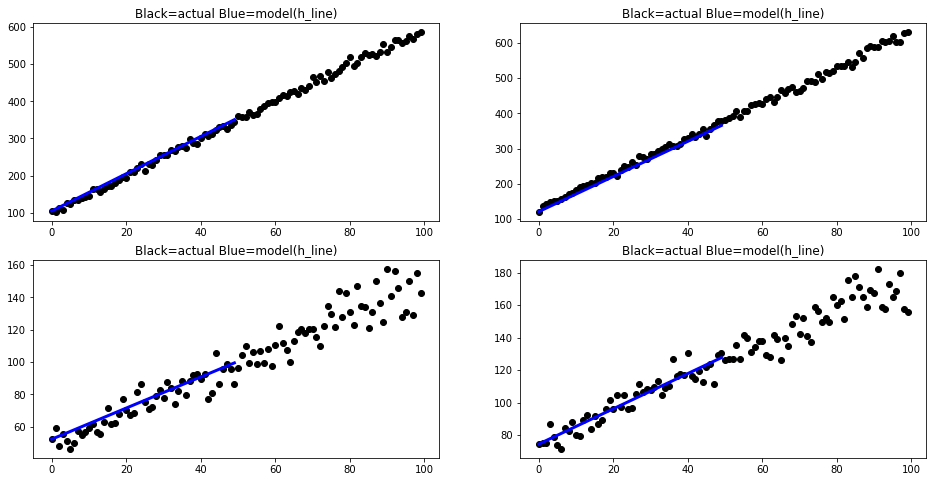

In [58]:
axes = plt.figure(figsize=(16,8))
# Plot outputs
plt.subplot(2,2,1)
plt.scatter(x, y1,  color='black')
plt.plot(fm1.t, fm1.y_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,2)
plt.scatter(x, y2,  color='black')
plt.plot(fm2.t, fm2.y_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,3)
plt.scatter(x, y3,  color='black')
plt.plot(fm3.t, fm3.y_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,4)
plt.scatter(x, y4,  color='black')
plt.plot(fm4.t, fm4.y_hat, color='blue', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

Text(0.5, 1.0, 'Black=actual Blue=model(h_line)')

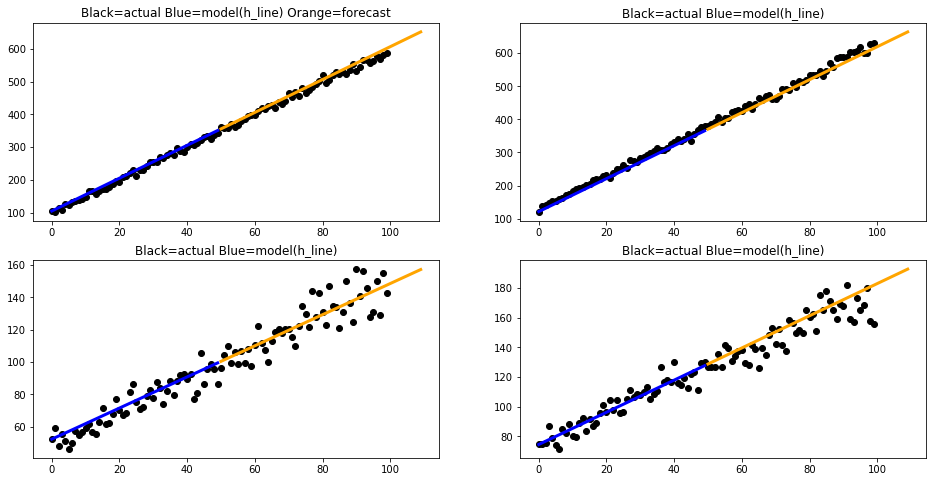

In [59]:
# make forecast. and plot the forecast.
fm1.forecast(y1_train, 30)
fm2.forecast(y2_train, 30)
fm3.forecast(y3_train, 30)
fm4.forecast(y4_train, 30)


axes = plt.figure(figsize=(16,8))
# Plot outputs
plt.subplot(2,2,1)
plt.scatter(x, y1,  color='black')
plt.plot(fm1.t, fm1.y_hat, color='blue', linewidth=3)
plt.plot(fm1.t_forecast, fm1.y_forecast, color='orange', linewidth=3)
plt.title("Black=actual Blue=model(h_line) Orange=forecast")

plt.subplot(2,2,2)
plt.scatter(x, y2,  color='black')
plt.plot(fm2.t, fm2.y_hat, color='blue', linewidth=3)
plt.plot(fm2.t_forecast, fm2.y_forecast, color='orange', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,3)
plt.scatter(x, y3,  color='black')
plt.plot(fm3.t, fm3.y_hat, color='blue', linewidth=3)
plt.plot(fm3.t_forecast, fm3.y_forecast, color='orange', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

plt.subplot(2,2,4)
plt.scatter(x, y4,  color='black')
plt.plot(fm4.t, fm4.y_hat, color='blue', linewidth=3)
plt.plot(fm4.t_forecast, fm4.y_forecast, color='orange', linewidth=3)
plt.title("Black=actual Blue=model(h_line)")

In [60]:
fm1.t_forecast

array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109])

In [61]:
fm1.y_forecast

array([355.58663377, 360.60357862, 365.62052347, 370.63746832,
       375.65441317, 380.67135802, 385.68830288, 390.70524773,
       395.72219258, 400.73913743, 405.75608228, 410.77302713,
       415.78997198, 420.80691683, 425.82386169, 430.84080654,
       435.85775139, 440.87469624, 445.89164109, 450.90858594,
       455.92553079, 460.94247564, 465.95942049, 470.97636535,
       475.9933102 , 481.01025505, 486.0271999 , 491.04414475,
       496.0610896 , 501.07803445, 506.0949793 , 511.11192416,
       516.12886901, 521.14581386, 526.16275871, 531.17970356,
       536.19664841, 541.21359326, 546.23053811, 551.24748296,
       556.26442782, 561.28137267, 566.29831752, 571.31526237,
       576.33220722, 581.34915207, 586.36609692, 591.38304177,
       596.39998663, 601.41693148, 606.43387633, 611.45082118,
       616.46776603, 621.48471088, 626.50165573, 631.51860058,
       636.53554543, 641.55249029, 646.56943514, 651.58637999])

In [62]:
forecasts = np.stack([fm1.t_forecast, fm1.y_forecast]).T # .shape

forecasts.shape

(60, 2)

In [63]:
# Test data

x_test, y1_test

(array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([464.63763237, 451.61512747, 469.37388648, 455.33991783,
        479.8717553 , 463.61812392, 473.34734359, 482.02144157,
        493.38719854, 502.21467986, 519.39022738, 494.66161914,
        504.03552636, 519.33171654, 529.31387907, 524.34944429,
        528.53880654, 523.14409444, 534.02256927, 553.24316979,
        532.97495577, 545.91901534, 565.56837274, 565.74961932,
        557.00881366, 563.03609698, 577.29038912, 567.37429098,
        580.73324568, 586.96768801]))

In [64]:
tests = np.stack([x_test, y1_test]).T # .shape
tests.shape


(30, 2)

In [65]:
tests[:,0] # get the time index that we have test data

array([70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., 99.])

In [80]:
idx = tests[:,0]

filt = np.intersect1d(forecasts[:,0],idx)

cumerr = 0.0

for r in forecasts[:,]:
    # print(r[0] in idx)
    if r[0] in idx:
        forecast = r[1] # forecast
        actual = tests[r[0]]
        error = (actual - forecast) ** 2
        cumerr += error
print(cumerr)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices